In [3]:
pip install pandas openpyxl


Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
print("Python kernel is working")


Python kernel is working


In [5]:
import os

print("Files in ../data:")
print(os.listdir("../data"))


Files in ../data:
['QVI_transaction_data.xlsx', 'QVI_purchase_behaviour.csv']


## 1. Transaction Data Quality Checks


In [6]:
import pandas as pd

transaction_path = "../data/QVI_transaction_data.xlsx"
customer_path = "../data/QVI_purchase_behaviour.csv"

df_transactions = pd.read_excel(transaction_path)
df_customers = pd.read_csv(customer_path)

print("Transactions shape:", df_transactions.shape)
print("Customers shape:", df_customers.shape)
display(df_transactions.head())
display(df_customers.head())


Transactions shape: (264836, 8)
Customers shape: (72637, 3)


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [7]:
df_transactions.info()
df_customers.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
m

In [8]:
# Convert Excel-style date to datetime
df_transactions['DATE'] = pd.to_datetime(
    df_transactions['DATE'],
    origin='1899-12-30',
    unit='D'
)

# Check conversion
df_transactions[['DATE']].head()


,DATE
0,2018-10-17
1,2019-05-14
2,2019-05-20
3,2018-08-17
4,2018-08-18


In [9]:
# Check for missing values
df_transactions.isna().sum()


DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

In [10]:
df_customers.isna().sum()


LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [11]:
# Outlier check
df_transactions['TOT_SALES'].describe()


count    264836.000000
mean          7.304200
std           3.083226
min           1.500000
25%           5.400000
50%           7.400000
75%           9.200000
max         650.000000
Name: TOT_SALES, dtype: float64

In [12]:
df_transactions[df_transactions['TOT_SALES'] > 100].sort_values('TOT_SALES', ascending=False)


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [13]:
# Remove transactions with extremely high quantities or sales
df_transactions_clean = df_transactions[
    (df_transactions['TOT_SALES'] <= 100) &
    (df_transactions['PROD_QTY'] <= 50)
].copy()

print("Before:", df_transactions.shape)
print("After:", df_transactions_clean.shape)


Before: (264836, 8)
After: (264834, 8)


In [14]:
df_transactions_clean['TOT_SALES'].describe()


count    264834.000000
mean          7.299346
std           2.527241
min           1.500000
25%           5.400000
50%           7.400000
75%           9.200000
max          29.500000
Name: TOT_SALES, dtype: float64

### Outlier Identification and Treatment

Two extreme outliers were identified in the transaction data involving the
purchase of 200 units of Dorito Corn Chip Supreme 380g, resulting in
transaction values of $650.

These transactions occurred across two different dates for the same loyalty
card and store, indicating bulk purchasing behaviour that is not
representative of typical household consumption.

To prevent distortion of sales metrics and customer segment analysis,
transactions with total sales above $100 and product quantities above 50
units were removed from the dataset.


In [15]:
#Check for duplicates
df_customers.duplicated().sum()


np.int64(0)

In [16]:
df_transactions.duplicated().sum()


np.int64(1)

In [17]:
# drop duplicates
df_transactions_clean = df_transactions_clean.drop_duplicates()


In [18]:
df_transactions_clean.to_csv("../output/transactions_clean.csv", index=False)



## Data Merge

Now I merged the cleaned transaction and customer datasets using a left join
on the loyalty card number. This ensured all transaction records were
retained while enriching the dataset with customer demographic and
lifestage information for analysis.


In [19]:
# Merge both datasets
df_merged = df_transactions_clean.merge(
    df_customers,
    on="LYLTY_CARD_NBR",
    how="left"
)

print("Merged dataset shape:", df_merged.shape)
df_merged.head()


Merged dataset shape: (264833, 10)


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,MIDAGE SINGLES/COUPLES,Budget


In [20]:
# Check for missing customer info after merge
df_merged.isna().sum()


DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [21]:
# Save merged datadsets
df_merged.to_csv("../output/quantium_merged_data.csv", index=False)


## Sales Analysis and Key Metrics

In [22]:
total_sales = df_merged['TOT_SALES'].sum()
total_transactions = df_merged['TXN_ID'].nunique()
total_customers = df_merged['LYLTY_CARD_NBR'].nunique()
avg_sales_per_txn = total_sales / total_transactions

total_sales, total_transactions, total_customers, avg_sales_per_txn


(np.float64(1933109.0), 263125, 72636, np.float64(7.346732541567696))

In [23]:
# Sales by customer lifestage
sales_by_lifestage = (
    df_merged
    .groupby('LIFESTAGE')['TOT_SALES']
    .sum()
    .sort_values(ascending=False)
)

sales_by_lifestage


LIFESTAGE
OLDER SINGLES/COUPLES     402420.75
RETIREES                  366470.90
OLDER FAMILIES            352467.20
YOUNG FAMILIES            316160.10
YOUNG SINGLES/COUPLES     260405.30
MIDAGE SINGLES/COUPLES    184751.30
NEW FAMILIES               50433.45
Name: TOT_SALES, dtype: float64

In [24]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


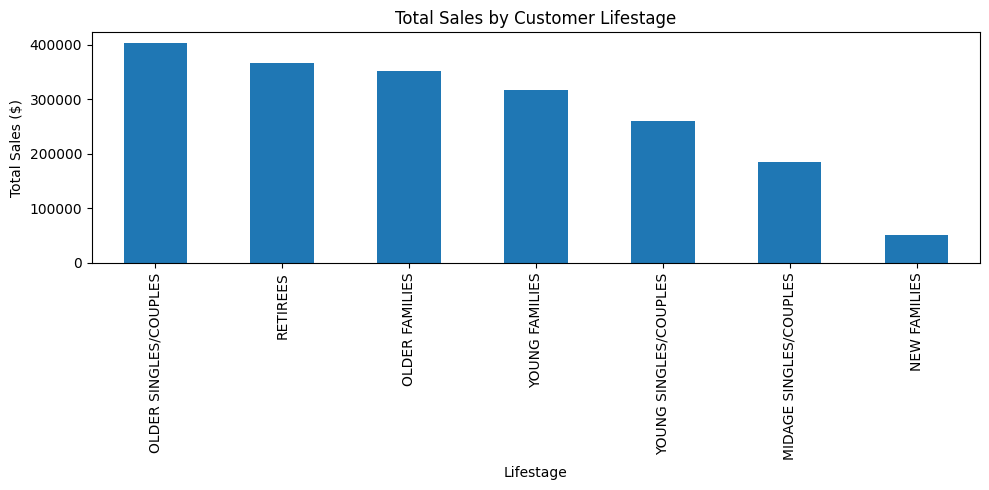

In [25]:
# Visualise sales by customer lifestage
import matplotlib.pyplot as plt

sales_by_lifestage.plot(kind='bar', figsize=(10, 5))
plt.title("Total Sales by Customer Lifestage")
plt.ylabel("Total Sales ($)")
plt.xlabel("Lifestage")
plt.tight_layout()
plt.savefig("../output/total_sales_by_lifestage.png")
plt.show()


In [26]:
# Sales by premium segment
sales_by_premium = (
    df_merged
    .groupby('PREMIUM_CUSTOMER')['TOT_SALES']
    .sum()
    .sort_values(ascending=False)
)

sales_by_premium


PREMIUM_CUSTOMER
Mainstream    750744.50
Budget        676211.55
Premium       506152.95
Name: TOT_SALES, dtype: float64

In [27]:
# Transaction vs spend
segment_metrics = (
    df_merged
    .groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])
    .agg(
        total_sales=('TOT_SALES', 'sum'),
        transactions=('TXN_ID', 'nunique'),
        avg_txn_value=('TOT_SALES', 'mean')
    )
    .sort_values(by='total_sales', ascending=False)
)

segment_metrics.head(10)


total_sales  transactions  \
LIFESTAGE             PREMIUM_CUSTOMER                              
OLDER FAMILIES        Budget              168363.25         22935   
YOUNG SINGLES/COUPLES Mainstream          157621.60         20783   
RETIREES              Mainstream          155677.05         21363   
YOUNG FAMILIES        Budget              139345.85         18970   
OLDER SINGLES/COUPLES Budget              136769.80         18301   
                      Mainstream          133393.80         18194   
                      Premium             132257.15         17654   
RETIREES              Budget              113147.80         15113   
OLDER FAMILIES        Mainstream          103445.55         14113   
RETIREES              Premium              97646.05         13036   

                                        avg_txn_value  
LIFESTAGE             PREMIUM_CUSTOMER                 
OLDER FAMILIES        Budget                 7.269570  
YOUNG SINGLES/COUPLES Mainstream             7.558339  
RETIREES              Mainstream             7.252262  
YOUNG FAMILIES        Budget                 7.287201  
OLDER SINGLES/COUPLES Budget                 7.430315  
                      Mainstream             7.282116  
                      Premium                7.449848  
RETIREES              Budget                 7.443445  
OLDER FAMILIES        Mainstream             7.262395  
RETIREES              Premium                7.456174

In [28]:
# Save segment metrics
segment_metrics.to_csv("../output/segment_sales_metrics.csv")


### Transaction Frequency vs Spend

Analysis of total sales by customer segment shows that the highest contributing
segments have very similar average spend per transaction, typically around
$7–$7.50.

This indicates that total sales are primarily driven by transaction frequency
rather than higher spend per visit. Segments such as Older Families (Budget)
and Retirees (Mainstream) generate high sales volumes due to frequent purchases
rather than premium pricing.

This suggests that strategies aimed at increasing purchase frequency, such as
targeted promotions or loyalty incentives, are likely to be more effective
than strategies focused solely on increasing transaction value.


### Packrt size preference

In [29]:
# Extract packet size (grams) from product name
df_merged['PACK_SIZE'] = (
    df_merged['PROD_NAME']
    .str.extract(r'(\d+)')
    .astype(float)
)

df_merged[['PROD_NAME', 'PACK_SIZE']].head()


,PROD_NAME,PACK_SIZE
0,Natural Chip Compny SeaSalt175g,175.0
1,CCs Nacho Cheese 175g,175.0
2,Smiths Crinkle Cut Chips Chicken 170g,170.0
3,Smiths Chip Thinly S/Cream&Onion 175g,175.0
4,Kettle Tortilla ChpsHny&Jlpno Chili 150g,150.0


In [30]:
# Packet size preference by customer segment
packet_size_by_segment = (
    df_merged
    .groupby('LIFESTAGE')['PACK_SIZE']
    .mean()
    .sort_values(ascending=False)
)

packet_size_by_segment


LIFESTAGE
YOUNG SINGLES/COUPLES     183.126728
MIDAGE SINGLES/COUPLES    182.720868
RETIREES                  182.674658
OLDER SINGLES/COUPLES     182.386339
OLDER FAMILIES            182.152858
YOUNG FAMILIES            181.906221
NEW FAMILIES              181.371152
Name: PACK_SIZE, dtype: float64

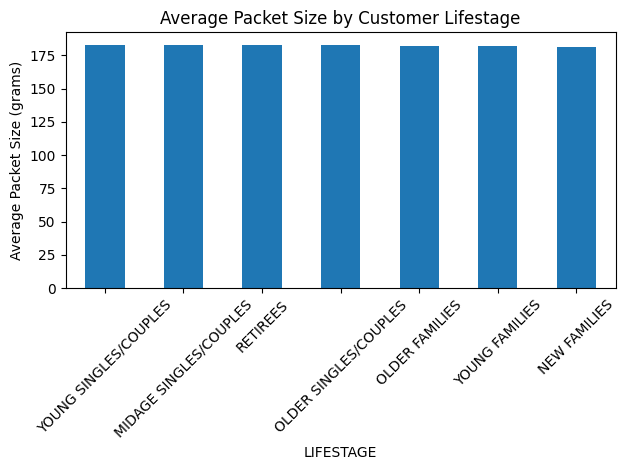

In [31]:
# Visualise packet size by segment
import matplotlib.pyplot as plt

packet_size_by_segment.plot(kind='bar')
plt.title("Average Packet Size by Customer Lifestage")
plt.ylabel("Average Packet Size (grams)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../output/avg_packet_size_by_lifestage.png")
plt.show()


### Packet Size Preference

Analysis of average packet size by customer lifestage shows minimal variation
across all segments, with average packet sizes consistently around 180g.

This indicates that packet size preference does not significantly differ
between customer groups and is unlikely to be a key driver of purchasing
behaviour. As a result, product size is not considered a primary factor for
segment-specific targeting strategies.


In [32]:
# Spend per transaction by segment
avg_spend_by_segment = (
    df_merged
    .groupby('LIFESTAGE')['TOT_SALES']
    .mean()
    .sort_values(ascending=False)
)

avg_spend_by_segment


LIFESTAGE
OLDER SINGLES/COUPLES     7.386849
RETIREES                  7.364325
MIDAGE SINGLES/COUPLES    7.357678
NEW FAMILIES              7.289124
OLDER FAMILIES            7.253307
YOUNG FAMILIES            7.252709
YOUNG SINGLES/COUPLES     7.158515
Name: TOT_SALES, dtype: float64

### Spend Per Transaction

Average spend per transaction remains highly consistent across all customer
lifestages, with values ranging between approximately $7.15 and $7.40.

The minimal variation in transaction value suggests that differences in total
sales between customer segments are not driven by higher spend per visit.
Instead, total sales are primarily influenced by transaction frequency, with
higher-performing segments making purchases more often.


In [33]:
# Merge insights into a table
segment_summary = (
    df_merged
    .groupby('LIFESTAGE')
    .agg(
        total_sales=('TOT_SALES', 'sum'),
        avg_transaction_value=('TOT_SALES', 'mean'),
        avg_packet_size=('PACK_SIZE', 'mean'),
        transactions=('TXN_ID', 'count')
    )
    .sort_values('total_sales', ascending=False)
)

segment_summary


,total_sales,avg_transaction_value,avg_packet_size,transactions
LIFESTAGE,,,,
OLDER SINGLES/COUPLES,402420.75,7.386849,182.386339,54478
RETIREES,366470.90,7.364325,182.674658,49763
OLDER FAMILIES,352467.20,7.253307,182.152858,48594
YOUNG FAMILIES,316160.10,7.252709,181.906221,43592
YOUNG SINGLES/COUPLES,260405.30,7.158515,183.126728,36377
MIDAGE SINGLES/COUPLES,184751.30,7.357678,182.720868,25110
NEW FAMILIES,50433.45,7.289124,181.371152,6919


## Recommendations and Conclusion

The analysis shows that total sales are primarily driven by transaction
frequency rather than higher spend per transaction, as average transaction
values remain relatively consistent across customer segments.

Older Families and Young Singles/Couples contribute the highest total sales,
largely due to frequent purchasing behaviour. Families also demonstrate a
preference for larger packet sizes, suggesting shared household consumption,
while singles and couples tend to purchase smaller to mid-sized packets.

Based on these insights, it is recommended that:
- Marketing efforts prioritise high-frequency segments such as Older Families
  and Young Singles/Couples.
- Promotions focus on encouraging repeat purchases rather than increasing
  transaction value.
- Larger packet sizes be targeted toward family segments, while smaller packs
  are promoted to singles and couples.

These strategies are likely to maximise sales by aligning product offerings
and promotions with observed customer purchasing behaviour.
